# Clustering by RNA: Integration

*See the original hypothesis in `notebooks/cluster-rna.ipynb`*

Integrating data from [Poscablo 2024](https://doi.org/10.1016/j.cell.2024.04.018) and an [internal perinatal nicotine exposure dataset (dubbed PNE)](https://cells.ucsc.edu/?ds=mouse-pne-project+bonemarrow) may provide more insight. 

**Hypothesis**: When comparing young and old HSCs, old HSCs form distinct subclusters that may inform whether said old HSC would differentiate down the known hematopoiesis tree or to become a non-canonical MKP.

In [48]:
# setup: imports

import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pandas as pd

from pathlib import Path
from typing import Any
import pyrootutils

# setup: path constants

ROOT = pyrootutils.setup_root(Path.cwd(), indicator='.git')
DATA = ROOT / "data"
FIGURES = ROOT / "figures/cluster-rna-integrated"

POSCABLO_PATH = DATA / "rna_annotation_normalized.h5ad"
PNE_PATH = DATA / "pne-bonemarrow.h5ad"

# setup: verify paths

for path in POSCABLO_PATH, PNE_PATH:
    if not path.exists():
        raise FileNotFoundError(f"Could not find required input: {str(path)}")

FIGURES.mkdir(parents=True, exist_ok=True)

Let's render our two to-be-integrated anndata objects and view their current UMAP embeddings to get a sense of what our data looks like. These datasets share label:color maps, so after guaranteeing that property we can visualize them with a shared legend.

<Axes: title={'center': 'predicted_cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>

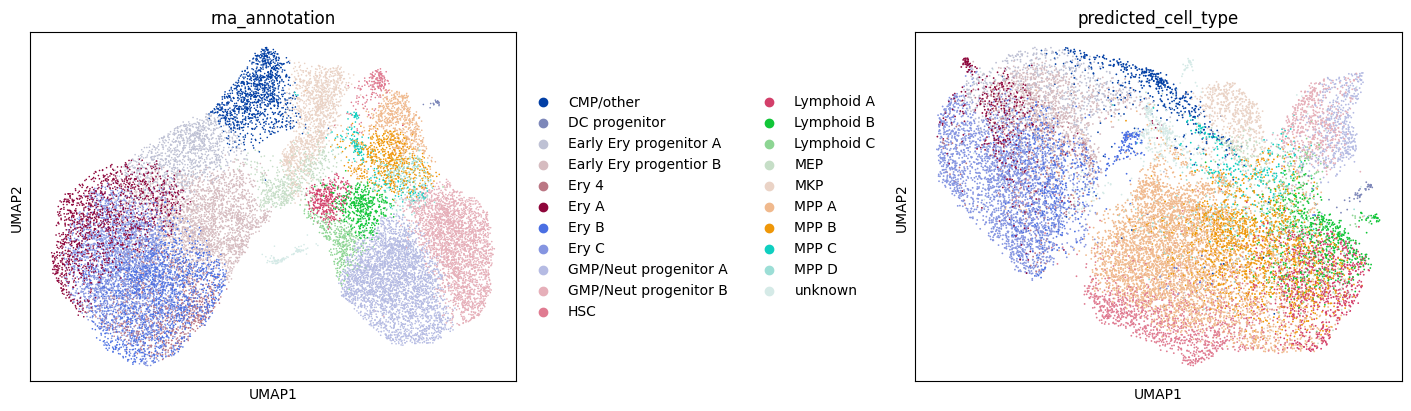

In [ ]:
poscablo = sc.read_h5ad(filename=POSCABLO_PATH, backed=True)
pne = sc.read_h5ad(filename=PNE_PATH, backed=True)

# if poscablo and pne share the same legend, only plot one of em
pne_legend_loc = None if all(poscablo.uns['rna_annotation_colors'] == pne.uns['predicted_cell_type_colors']) else 'right margin'

fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(14, 4))
axs[0] = sc.pl.umap(adata=poscablo, color=['rna_annotation'], ax=axs[0], show=False)
axs[1] = sc.pl.umap(adata=pne, color=['predicted_cell_type'], ax=axs[1], show=False, legend_loc=pne_legend_loc)

A little sanity check on the individual samples sequenced for the PNE dataset reveals that there is virtually no intra-dataset batch effects that may impact this analysis.

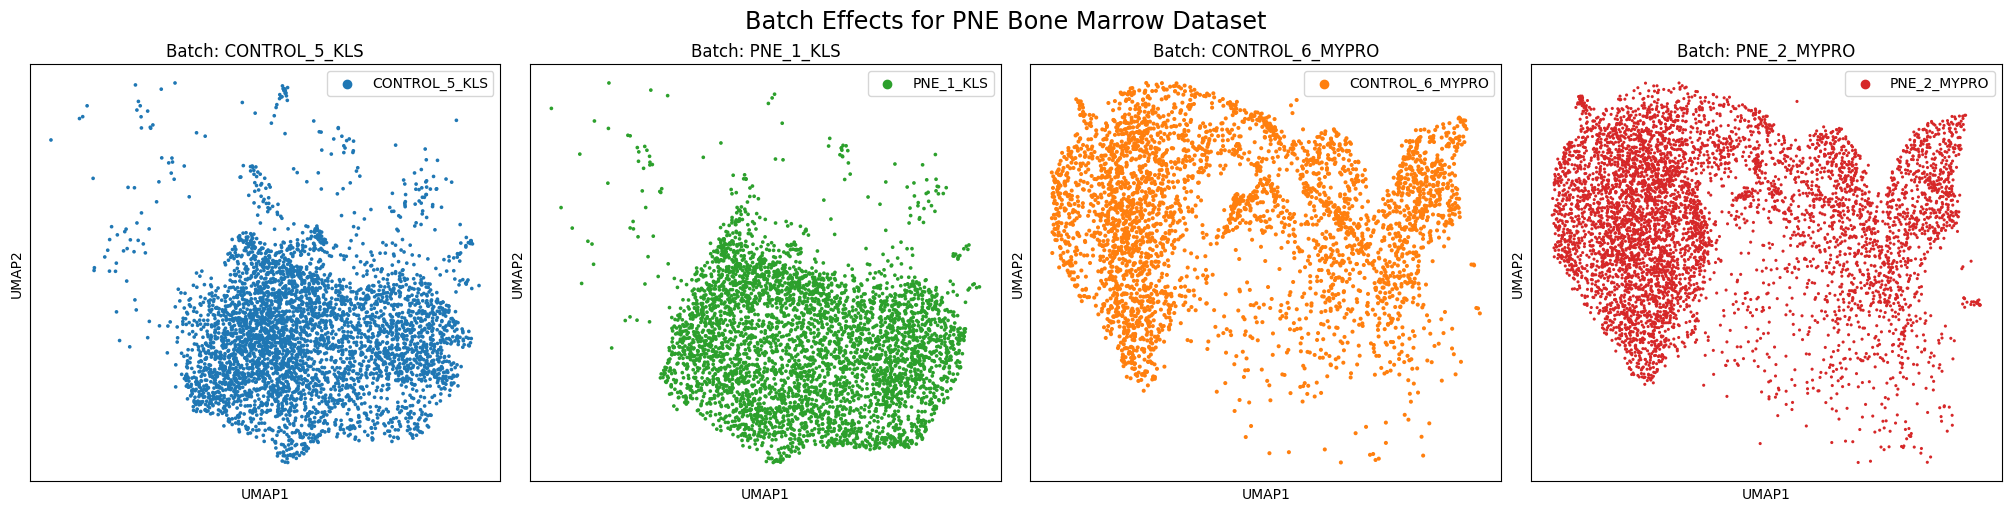

In [89]:
def plot_batches(adata: sc.AnnData, batch_col: str, suptitle: str = "Batches") -> None:
    batches = adata.obs[batch_col].unique()
    fig, axs = plt.subplots(
        nrows=1, 
        ncols=len(batches), 
        figsize=(5 * len(batches), 5), 
        constrained_layout=True
    )
    fig.suptitle(suptitle, size='xx-large')
    for ax, batch in zip(axs, batches):
        sc.pl.umap(
            adata=adata[adata.obs[batch_col] == batch], 
            color=batch_col, 
            ax=ax, 
            show=False, 
            title=f"Batch: {batch}", 
            legend_loc='best'
        )

plot_batches(adata=pne, batch_col='Sample', suptitle="Batch Effects for PNE Bone Marrow Dataset")

Adding `age` and `batch` features to each dataset.

In [60]:
pne.obs['Age'] = pd.Categorical(['Young'] * len(pne), categories=poscablo.obs['Age'].cat.categories)

pne.obs['batch'] = 'pne'
poscablo.obs['batch'] = 'poscablo'

In [ ]:
# merge datasets

joint = sc.concat(
    adatas=[poscablo, pne],
    axis='var'
)
joint